# Wumpus World - Logical Agent Visualization

This notebook visualizes:
1. **The actual world** - where pits, wumpus, and gold really are
2. **Agent's knowledge base** - what the agent knows (safe, dangerous, unknown)
3. **Agent's path** - the route taken through the cave

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
# Matplotlib settings for better animations
%matplotlib widget

# Import our modules
from solution import Agent
from environment import WumpusWorld
from wumpus import Actions, Percepts, Orientation
from wumpus_visualizer import StepSimulator

## 💻 Run the Simulation

### ▶️ : Step by step

In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import threading
import time
import matplotlib.pyplot as plt

# Create simulator
sim = StepSimulator()

# Output area
out = widgets.Output(layout={
    "border": "1px solid gray",
    "padding": "8px",
    "min_height": "300px"
})

# Global control flag
playing = False
play_thread = None

# -------------------
# Button callbacks
# -------------------
def on_step_clicked(b):
    with out:
        clear_output(wait=True)
        fig, status = sim.step()
        if fig:
            display(fig)
            plt.close(fig)
        print(f"Status: {status}")

def on_reset_clicked(b):
    global playing
    playing = False
    time.sleep(0.3)
    with out:
        clear_output(wait=True)
        sim.reset()
        fig = sim.viz.visualize()
        display(fig)
        plt.close(fig)
        print("Reset")

def on_play_clicked(b):
    global playing, play_thread
    if not playing:
        playing = True
        play_thread = threading.Thread(target=autoplay, daemon=True)
        play_thread.start()
        print("Started autoplay")


# -------------------
# Buttons
# -------------------
step_btn = widgets.Button(description="▶ Step", button_style="success")
reset_btn = widgets.Button(description="⟲ Reset", button_style="warning")

for btn in [step_btn, reset_btn, play_btn, pause_btn]:
    btn.layout = widgets.Layout(width="120px", height="40px")

step_btn.on_click(on_step_clicked)
reset_btn.on_click(on_reset_clicked)


# -------------------
# Speed slider
# -------------------
speed_slider = widgets.FloatSlider(
    value=0.3,
    min=0.05,
    max=1.0,
    step=0.05,
    description="Delay (s):",
    continuous_update=False
)

# -------------------
# Layout
# -------------------
title = widgets.HTML("<h3 style='text-align:center;'>🧠 Wumpus World Simulator</h3>")
controls = widgets.HBox(
    [step_btn, reset_btn,],
    layout=widgets.Layout(justify_content="center", gap="10px")
)

ui = widgets.VBox(
    [title, controls, out],
    layout=widgets.Layout(
        border="2px solid #444",
        padding="10px",
        width="100%"
    )
)

display(ui)

# Initial display
with out:
    fig = sim.viz.visualize()
    display(fig)
    plt.close(fig)
    print("Ready! Click Step or Play")

### ⏯️: Automatic animation

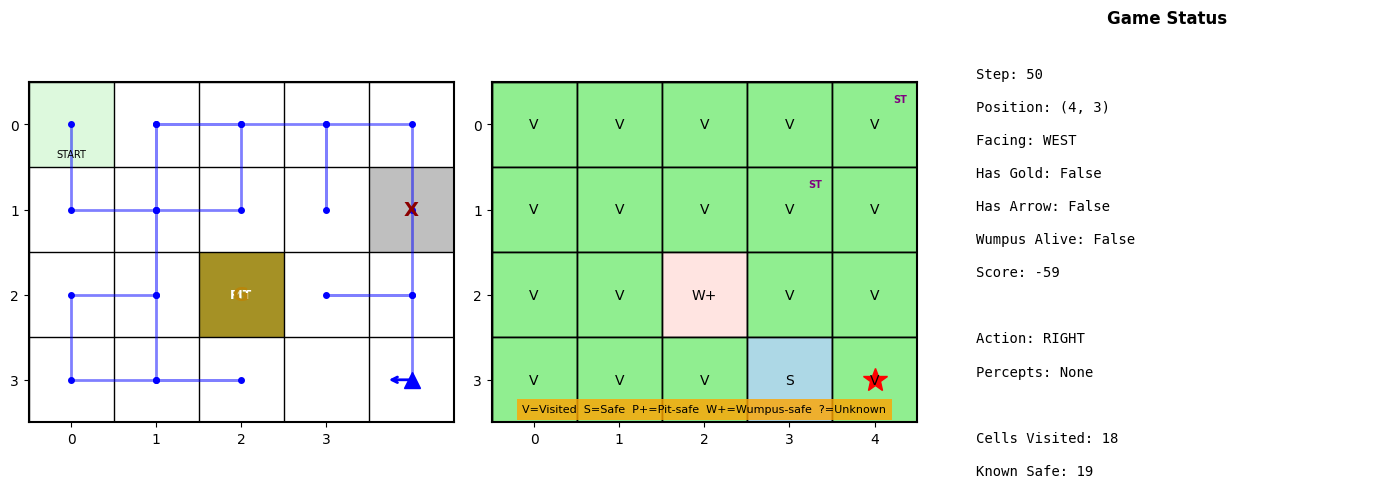


Status: Running... Score: -59


In [20]:
# Run full simulation with animation
sim = StepSimulator((5,4))
sim.run_all(max_steps=50, delay=0.1)

### 💾: Safe as gif

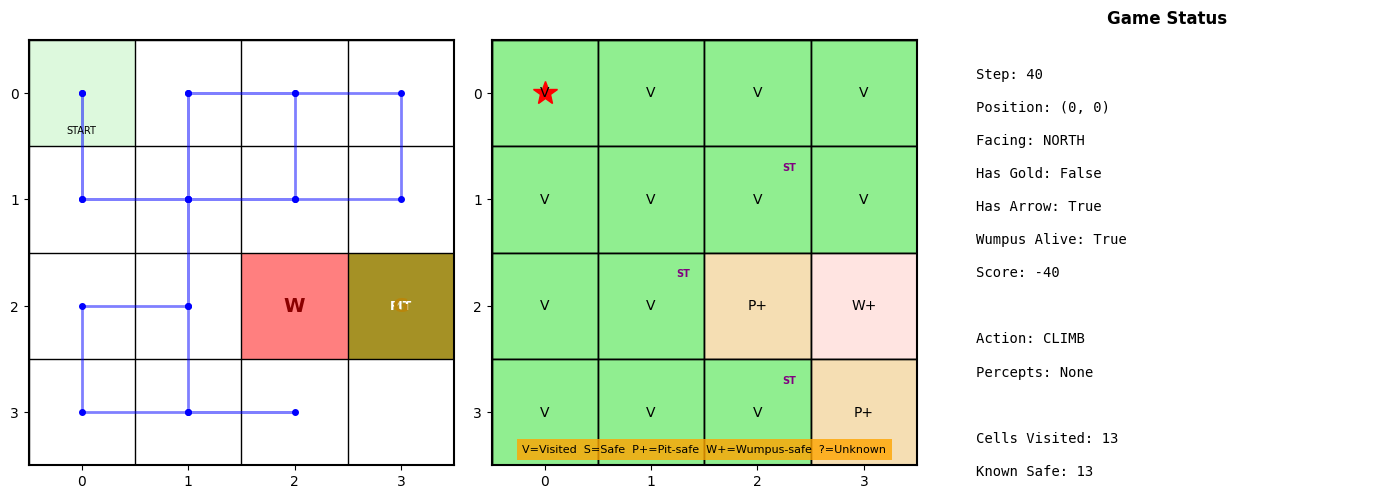


Step 40: Escaped (no gold). Score: -40
Saved GIF as wumpus_sim.gif


In [21]:
sim = StepSimulator()
sim.run_and_save_gif()

## 📊 Multiple episodes statistics

Running 10000 episodes...


RESULTS
Episodes: 10000
Wins: 5267 (52.7%)
Deaths: 0 (0.0%)
Escapes (no gold): 4733
Average Score: 506.7
Average Steps: 17.8


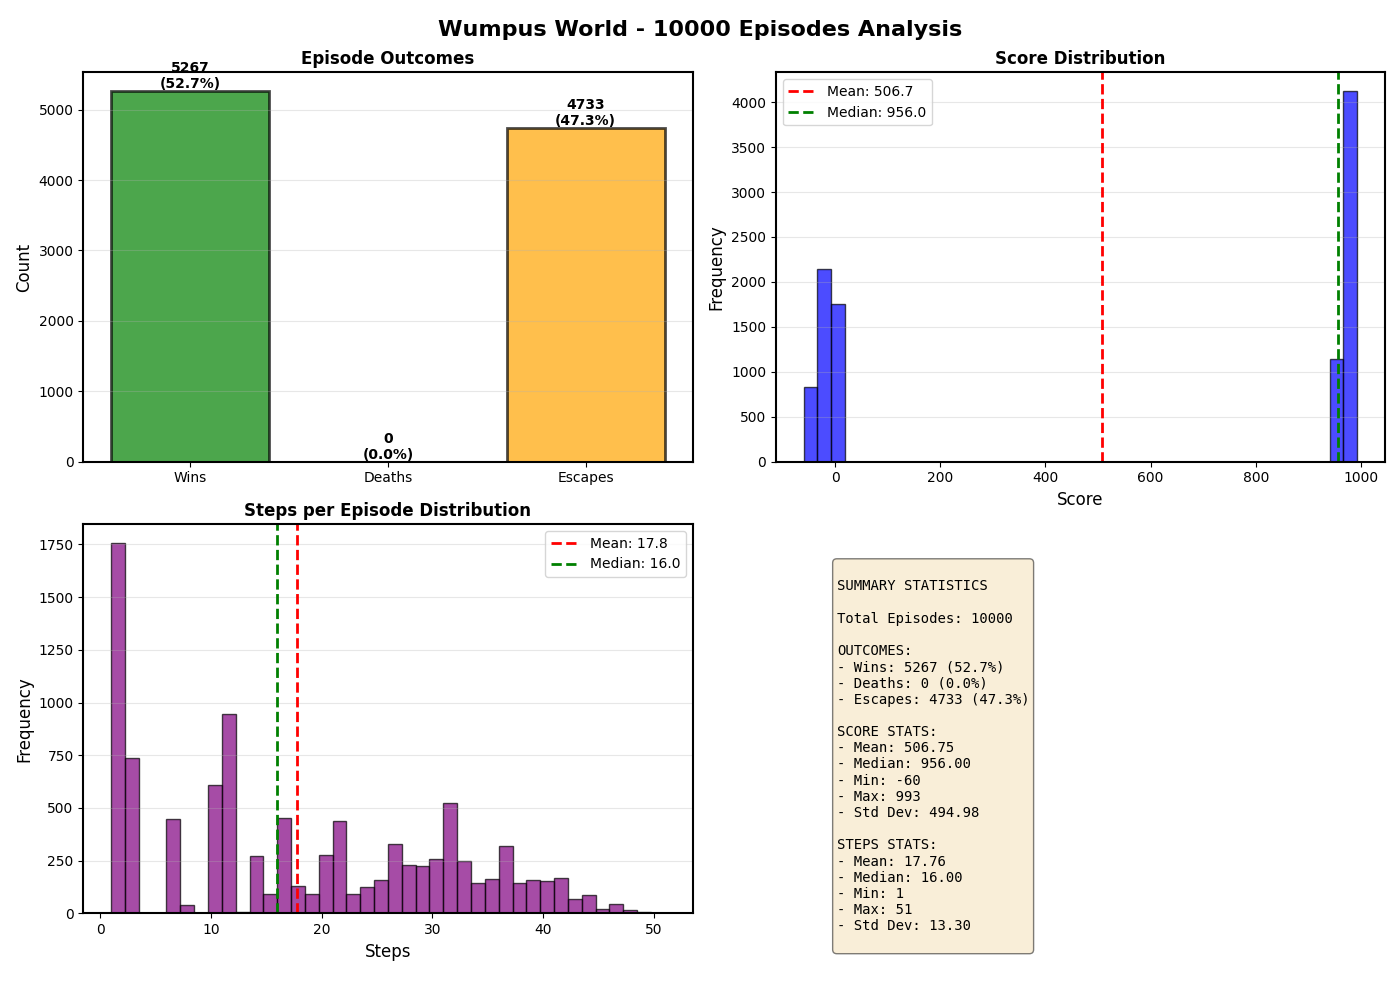

In [19]:
from environment import run_experiments
import matplotlib.pyplot as plt
import numpy as np

n_episodes = 10000
# Run experiments and collect detailed data
print(f"Running {n_episodes} episodes...")
stats = run_experiments(Agent, n_episodes=n_episodes, verbose=False)

# Check if we have detailed data
if 'scores' not in stats or 'steps' not in stats:
    print("\nCollecting detailed episode data...")
    from environment import WumpusWorld
    
    # Manually collect detailed stats
    all_scores = []
    all_steps = []
    wins = 0
    deaths = 0
    escapes = 0
    
    for episode in range(n_episodes):
        
        agent = Agent(size=(4,4))
        agent.new_episode()
        world = WumpusWorld(size=(4,4))
        
        done = False
        steps = 0
        
        percept = world.get_percept()
        
        while not done:
            action = agent.get_action(percept, reward=0)
            percept, reward, done, info = world.step(action)
            steps += 1
            
            if steps > 100:  # Safety limit
                break
        
        state = world.get_state()
        all_scores.append(state['score'])
        all_steps.append(steps)
        
        if state['has_gold'] and state['exited']:
            wins += 1
        elif not state['agent_alive']:
            deaths += 1
        else:
            escapes += 1
    
    # Update stats
    stats['scores'] = all_scores
    stats['steps'] = all_steps
    stats['wins'] = wins
    stats['deaths'] = deaths
    stats['escapes'] = escapes
    stats['n_episodes'] = n_episodes
    stats['win_rate'] = wins / n_episodes
    stats['death_rate'] = deaths / n_episodes
    stats['avg_score'] = np.mean(all_scores)
    stats['avg_steps'] = np.mean(all_steps)

# Print results
print("\n" + "="*40)
print("RESULTS")
print("="*40)
print(f"Episodes: {stats['n_episodes']}")
print(f"Wins: {stats['wins']} ({stats['win_rate']*100:.1f}%)")
print(f"Deaths: {stats['deaths']} ({stats['death_rate']*100:.1f}%)")
print(f"Escapes (no gold): {stats['escapes']}")
print(f"Average Score: {stats['avg_score']:.1f}")
print(f"Average Steps: {stats['avg_steps']:.1f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f"Wumpus World - {stats['n_episodes']} Episodes Analysis", fontsize=16, fontweight='bold')

# 1. Outcome Distribution
ax1 = axes[0, 0]
outcomes = ['Wins', 'Deaths', 'Escapes']
counts = [stats['wins'], stats['deaths'], stats['escapes']]
colors = ['green', 'red', 'orange']
bars = ax1.bar(outcomes, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Episode Outcomes', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({count/stats["n_episodes"]*100:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Score Distribution
ax2 = axes[0, 1]
scores = stats['scores']
ax2.hist(scores, bins=40, color='blue', alpha=0.7, edgecolor='black')
ax2.axvline(stats['avg_score'], color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {stats["avg_score"]:.1f}')
median_score = np.median(scores)
ax2.axvline(median_score, color='green', linestyle='--', linewidth=2, 
            label=f'Median: {median_score:.1f}')
ax2.set_xlabel('Score', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Score Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Steps Distribution
ax3 = axes[1, 0]
steps = stats['steps']
ax3.hist(steps, bins=40, color='purple', alpha=0.7, edgecolor='black')
ax3.axvline(stats['avg_steps'], color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {stats["avg_steps"]:.1f}')
median_steps = np.median(steps)
ax3.axvline(median_steps, color='green', linestyle='--', linewidth=2, 
            label=f'Median: {median_steps:.1f}')
ax3.set_xlabel('Steps', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Steps per Episode Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Summary Statistics
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
SUMMARY STATISTICS

Total Episodes: {stats['n_episodes']}

OUTCOMES:
- Wins: {stats['wins']} ({stats['win_rate']*100:.1f}%)
- Deaths: {stats['deaths']} ({stats['death_rate']*100:.1f}%)
- Escapes: {stats['escapes']} ({stats['escapes']/stats['n_episodes']*100:.1f}%)

SCORE STATS:
- Mean: {stats['avg_score']:.2f}
- Median: {median_score:.2f}
- Min: {min(scores):.0f}
- Max: {max(scores):.0f}
- Std Dev: {np.std(scores):.2f}

STEPS STATS:
- Mean: {stats['avg_steps']:.2f}
- Median: {median_steps:.2f}
- Min: {min(steps):.0f}
- Max: {max(steps):.0f}
- Std Dev: {np.std(steps):.2f}
"""

ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()